<h1>0. Introduction</h1>

This notebook implements and runs a fraud detection model for credit-cards transactions using the Google Cloud platform. In this notebooks we will execute code to process data, train a tensorflow model, run predictions on new data and assess model performances.



**Before you start, you will need to:**

* Create a Google Cloud project and a bucket in Google Cloud Storage
* Install gcloud SDK to run gcloud commands: https://cloud.google.com/sdk/downloads

**You can also:**

* Go through the python code available here: https://source.developers.google.com/p/fraud-detection-example/r/fraud-detection


<h1>1. Environment set-up</h1>

**Authenticate with the gcloud command**

In [0]:
from google.colab import auth
auth.authenticate_user()

**Project information**

Hard-code your project information as environment variables to be used in the following steps.
* PROJECT_ID is your GCP project ID to use for this example
* BUCKET_ID is the name of your bucket to to store outputs for this example 
* BQ_TABLE_NAME is the name of your BQ table containing the raw data

In [58]:
%env PROJECT_ID=fraud-detection-example
%env BUCKET_ID=fraud-detection-example
%env BQ_TABLE_NAME=raw_data

env: PROJECT_ID=fraud-detection-example
env: BUCKET_ID=fraud-detection-example
env: BQ_TABLE_NAME=raw_data


**Set your GCP project id**

In [15]:
%%bash
gcloud config set project $PROJECT_ID

Updated property [core/project].


**Set up the dataset using Google BigQuery**

In your project, create a BigQuery dataset named 'fraud_detection' and create a table from the data stored in GCP public bucket by running the command below.


In [36]:
%%bash
bq load --project_id $PROJECT_ID --autodetect \
--source_format=CSV fraud_detection.$BQ_TABLE_NAME gs://fraud-detection-example/creditcard_proc.csv

Process is interrupted.


**Clone the git repository containing the necessary code**

It contains python code to process data, train a tensorflow model and run predictions.

In [7]:
!gcloud source repos clone fraud-detection --project=fraud-detection-example

ERROR: (gcloud.source.repos.clone) Directory path specified exists and is not empty


**Note: you may need to request access to the GCP bucket and repository**

**Current timestamp for unique naming**

We use the current timestamp as a string to ensure unique naming through the different steps of the process.

In [8]:
import os
import time

current_time = str(time.time()).replace('.', '')
current_time

'152286339827'

<h1>2. Run data preprocessing in Google Cloud Dataflow</h1>

In this part we run the data preprocessing in Google Cloud Dataflow using the Apache-Beam and Tensorflow-Transform libraries.

This step includes the following:
- reads data from BigQuery
- adds hash key value to each row
- scales data
- shuffles and splits data in train / validation / test sets
- oversamples train data
- stores data as TFRecord
- splits and stores test data into labels and features files

**Output path**

Hard-code the output path of data processing to be used in the following steps.

In [9]:
os.environ['DATAFLOW_OUTPUT_DIR'] = 'data_flow_output_dir-{}/'.format(
    current_time)
!echo $DATAFLOW_OUTPUT_DIR

data_flow_output_dir-152286339827/


**Note: depending on your configuration, you may need to install missing python packages**

In [10]:
!pip install apache_beam==2.4.0
!pip install tensorflow-transform==0.4.0

**Launch data processing job**

You need to specify the name of the table you stored in BigQuery and input it with the '--bq_table' argument.

In [11]:
%%bash
cd fraud-detection/
python preprocess.py \
--cloud \
--bq_table $BQ_TABLE_NAME \
--output_dir ${DATAFLOW_OUTPUT_DIR} \
--project_id $PROJECT_ID \
--bucket_id $BUCKET_ID

running sdist
running egg_info
writing requirements to trainer.egg-info/requires.txt
writing trainer.egg-info/PKG-INFO
writing top-level names to trainer.egg-info/top_level.txt
writing dependency_links to trainer.egg-info/dependency_links.txt
reading manifest file 'trainer.egg-info/SOURCES.txt'
writing manifest file 'trainer.egg-info/SOURCES.txt'
running check
creating trainer-1.0
creating trainer-1.0/constants
creating trainer-1.0/trainer
creating trainer-1.0/trainer.egg-info
creating trainer-1.0/utils
copying files to trainer-1.0...
copying setup.py -> trainer-1.0
copying constants/__init__.py -> trainer-1.0/constants
copying constants/constants.py -> trainer-1.0/constants
copying trainer/__init__.py -> trainer-1.0/trainer
copying trainer/input_fn_utils.py -> trainer-1.0/trainer
copying trainer/metrics.py -> trainer-1.0/trainer
copying trainer/model.py -> trainer-1.0/trainer
copying trainer/task.py -> trainer-1.0/trainer
copying trainer.egg-info/PKG-INFO -> trainer-1.0/trainer.egg-in

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



/usr/local/lib/python2.7/dist-packages/apache_beam/io/gcp/gcsio.py:166: DeprecationWarning: object() takes no parameters
  super(GcsIO, cls).__new__(cls, storage_client))


<h1>3. Training in Google Cloud ML-engine</h1>

**Set up environment variables**

Hard-code the output path for the training sep as well as the job name, to be used in the following steps.

In [12]:
os.environ['TRAINING_JOB_NAME'] = 'fraud_detection_training_job_{}'.format(
    current_time)
os.environ['TRAINING_OUTPUT_DIR'] = 'gs://{}/training_output_dir-{}'.format(
    os.environ['BUCKET_ID'], current_time)
print os.environ['TRAINING_JOB_NAME'], os.environ['TRAINING_OUTPUT_DIR']

aarg_fraud_detection_training_job_152286339827 gs://fraud-detection-example/training_output_dir-152286339827


**Set hyperparameters search configuration**

The training step includes hyperparameter tuning. Hyperparameter tuning (described in more details here: https://cloud.google.com/blog/big-data/2018/03/hyperparameter-tuning-on-google-cloud-platform-is-now-faster-and-smarter) is the concept of training and evaluating different parametrizations of a model to then pick the best performing one.
For this purpose we need to indicate which parameters we want to test and the range we want to try.

The ML-engine command takes in input a '.yaml' file that contains the configuration to use for hyperparameter tuning.

In [13]:
%%writefile fraud-detection/hyperparams.yaml
trainingInput:
  scaleTier: STANDARD_1
  hyperparameters:
    maxTrials: 10
    maxParallelTrials: 2
    enableTrialEarlyStopping: True
    goal: MAXIMIZE
    hyperparameterMetricTag: auc_precision_recall
    params:
    - parameterName: first_layer_size
      type: INTEGER
      minValue: 5
      maxValue: 50
      scaleType: UNIT_LINEAR_SCALE
    - parameterName: num_layers
      type: INTEGER
      discreteValues:
      minValue: 1
      maxValue: 2
      scaleType: UNIT_LINEAR_SCALE
    - parameterName: dropout
      type: DOUBLE
      minValue: 0.10
      maxValue: 0.50
      scaleType: UNIT_LINEAR_SCALE
    - parameterName: learning_rate
      type: DOUBLE
      minValue: 0.0001
      maxValue: 0.1
      scaleType: UNIT_LOG_SCALE

Overwriting fraud-detection/hyperparams.yaml


**Submit training job**

You can specify the maximum number of training steps with the '--max_steps' argument.

In [16]:
%%bash
cd fraud-detection/
gcloud ml-engine jobs submit training $TRAINING_JOB_NAME \
--module-name trainer.task \
--staging-bucket gs://${BUCKET_ID} \
--package-path ./trainer \
--region=us-central1 \
--runtime-version 1.4 \
--config=hyperparams.yaml \
-- \
--input_dir gs://${BUCKET_ID}/${DATAFLOW_OUTPUT_DIR} \
--output_dir ${TRAINING_OUTPUT_DIR} \
--max_steps 10000

jobId: aarg_fraud_detection_training_job_152286339827
state: QUEUED


Job [aarg_fraud_detection_training_job_152286339827] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe aarg_fraud_detection_training_job_152286339827

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs aarg_fraud_detection_training_job_152286339827


**Monitor with Tensorboard**

You can monitor in real-time the training of each model using Tensorboard. It allows to visualize different metrics such as the loss on the training and validation data.

In addition you can visualize the following validation metrics to assess the evolution of your model's performances through training:
- ROC AUC
- Precision-recall AUC
- Accuracy
- Other custom metrics

**Select which trial to visualize**

Here 1

In [24]:
%env TRIAL_NUMBER=1

env: TRIAL_NUMBER=1


**Run the following command on your local machine:**
```TRIAL_NUMBER=1
tensorboard --logdir=<TRAINING_OUTPUT_DIR>/trials/$TRIAL_NUMBER
```
Replace ```<TRAINING_OUTPUT_DIR>``` with the actual training output path. You can copy the output of the following cell:


In [25]:
! echo tensorboard --logdir=$TRAINING_OUTPUT_DIR/trials/$TRIAL_NUMBER

tensorboard --logdir=gs://fraud-detection-example/training_output_dir-152286339827/trials/1


**Monitor overall training in Google Cloud ML-engine**

You can also monitor the overall training in GCP, access the logs and results of hyperparameter tuning in the ML-engine console:

https://cloud.google.com/ml-engine/

<h1>4. Inferences in Google Cloud ML-engine</h1>

Once our model is trained and stored in Google Cloud Storage, we can add it to Cloud ML-engine and use it for batch inference on new data, among other things.
Different versions of a same model can be stored in the ML-engine. We will specify a name for the model and a unique name for the current version, based on current timestamp.

**Specify the best model trial to use**

After hyperparameter tuning we may have to pick between different trials and select the best performing one to use for inference. The next command defines which version to use moving forward. In this example the trial picked is 'TRIAL_NUMBER=1' but **you should adapt to pick the best performing model that you obtained after training.**

In [1]:
%env TRIAL_NUMBER=1

env: TRIAL_NUMBER=7


**Set up environment variables**

In [42]:
os.environ['MODEL_NAME'] = 'fraud_detection_test_nb'
os.environ['MODEL_VERSION'] = 'v_{}'.format(time.time()).replace('.', '')
temp = !echo $(gsutil ls ${TRAINING_OUTPUT_DIR}/trials/${TRIAL_NUMBER}/export/exporter/ | tail -1)
os.environ['MODEL_SAVED_NAME'] = temp[0]
del temp
print os.environ['MODEL_SAVED_NAME']

env: TRIAL_NUMBER=7
gs://fraud-detection-example/training_output_dir-152286339827/trials/7/export/exporter/1522868643/


**Create and save model in Google Cloud ML-engine**

We first need to add our trained model to Cloud ML-engine. We provide the path to the model we would like to use in Google Cloud Storage..

In [43]:
%%bash
gcloud ml-engine models create $MODEL_NAME \
--regions us-central1

ERROR: (gcloud.ml-engine.models.create) Resource in project [fraud-detection-example] is the subject of a conflict: Field: model.name Error: A model with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with the same name already exists.
    field: model.name


.. and add the current version to the GCP model created.

In [44]:
%%bash
gcloud ml-engine versions create $MODEL_VERSION \
--model $MODEL_NAME \
--origin $MODEL_SAVED_NAME \
--runtime-version 1.4

Creating version (this might take a few minutes)......
....................................................................................................................................................................................................done.


**Set up environment variables**

We need to specify the following:

* JOB_NAME: unique name for inference job
* FEATURES_INPUT_PATH: the path to the features to use for prediction (here it is in the output of the DataFlow job)
* PREDICTIONS_OUTPUT_PATH: the path to the directory to store the predictions to.

In [53]:
os.environ['JOB_NAME'] = '{}_{}'.format(
    os.environ['MODEL_NAME'],
    os.environ['MODEL_VERSION'])
os.environ['FEATURES_INPUT_PATH'] = 'gs://{}/{}split_data/split_data_TEST_features.txt*'.format(
    os.environ['BUCKET_ID'],
    os.environ['DATAFLOW_OUTPUT_DIR'])
os.environ['PREDICTIONS_OUTPUT_PATH'] = 'gs://{}/predictions/{}'.format(
    os.environ['BUCKET_ID'],
    os.environ['JOB_NAME'])
print os.environ['FEATURES_INPUT_PATH']
print os.environ['PREDICTIONS_OUTPUT_PATH']
print os.environ['JOB_NAME']

gs://fraud-detection-example/data_flow_output_dir-152286339827/split_data/split_data_TEST_features.txt*
gs://fraud-detection-example/predictions/aarg_fraud_detection_test_nb_v_152287181365
aarg_fraud_detection_test_nb_v_152287181365


**Submit prediction job**

Now that the model is saved, we can launch a training job by indicating the name of the model we just stored and the path to the data to be scored (here the test sample data from the DataFlow step).

In [54]:
%%bash
gcloud ml-engine jobs submit prediction $JOB_NAME \
--model $MODEL_NAME \
--input-paths $FEATURES_INPUT_PATH \
--output-path $PREDICTIONS_OUTPUT_PATH \
--region us-central1 \
--data-format TEXT \
--version $MODEL_VERSION

jobId: aarg_fraud_detection_test_nb_v_152287181365
state: QUEUED


Job [aarg_fraud_detection_test_nb_v_152287181365] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe aarg_fraud_detection_test_nb_v_152287181365

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs aarg_fraud_detection_test_nb_v_152287181365


**Monitor prediction job in Google Cloud ML-engine**

You can monitor the prediction job in the GCP ML-engine console:

https://cloud.google.com/ml-engine/

<h1>5. Assess model performances on out-of-sample data</h1>

We can assess how well our model performed on the out-of-sample data previously scored. For this purpose we will compare predictions to true labels and derive the precision-recall curve and its AUC. Precision-recall curve AUC is a relevant metric to assess our model's performances as it reflects the fraction of the fraudulent transactions we are able to predict and the accuracy of these predictions.

**Prepare data**

First, let's pull our predictions and true labels from Cloud Storage to our local environment in a 'predictions.txt' and 'labels.txt' file.

In [55]:
%%bash
ANALYSIS_OUTPUT_PATH=.
mkdir ${ANALYSIS_OUTPUT_PATH}/labels
gsutil cp gs://${BUCKET_ID}/${DATAFLOW_OUTPUT_DIR}split_data/split_data_TEST_labels.txt* labels/
cat ${ANALYSIS_OUTPUT_PATH}/labels/* > ${ANALYSIS_OUTPUT_PATH}/labels.txt

mkdir ${ANALYSIS_OUTPUT_PATH}/predictions
gsutil cp ${PREDICTIONS_OUTPUT_PATH}/prediction.results* ./predictions/
cat ${ANALYSIS_OUTPUT_PATH}/predictions/* > ${ANALYSIS_OUTPUT_PATH}/predictions.txt

mkdir: cannot create directory ‘./labels’: File exists
Copying gs://fraud-detection-example/data_flow_output_dir-152286339827/split_data/split_data_TEST_labels.txt-00000-of-00011...
Copying gs://fraud-detection-example/data_flow_output_dir-152286339827/split_data/split_data_TEST_labels.txt-00001-of-00011...
Copying gs://fraud-detection-example/data_flow_output_dir-152286339827/split_data/split_data_TEST_labels.txt-00002-of-00011...
Copying gs://fraud-detection-example/data_flow_output_dir-152286339827/split_data/split_data_TEST_labels.txt-00003-of-00011...
- [4 files][  1.3 MiB/  1.3 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m -o ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://fraud-detection-example/data_flow_output_dir-152286339827/split_data/split_data_TEST_labels

**Compute precision-recall curve**

We join the labels and precision based on their hash-key (added in the DataFlow step). These are not unique and may have a few duplicates that we get rid of.

We then plot the precision-recall curve and the corresponding AUC.

Precision-Recall AUC: 0.70


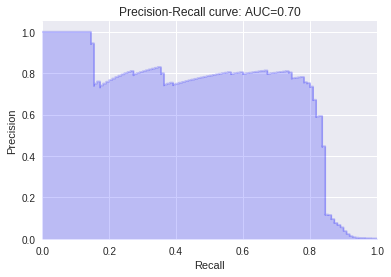

In [56]:
import argparse
import json
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

%matplotlib inline

def extract_from_json(path, key, values, proc=(lambda x: x)):
  """Extracts and parses data from json files and returns a dictionary.

  Args:
    path: string, path to input data.
    key: string, name of key column.
    values: string, name of column containing values to extract.
    proc: function, used to process values from input. Follows the signature:
      * Args:
        * x: string or tuple of string
      * Returns:
        string

  Returns:
    Dictionary of parsed data.
  """

  res = {}
  keys = []
  with open(path) as f:
    for line in f:
      line = json.loads(line)
      item_key = proc(line[key])
      res[item_key] = line[values]
      keys.append(item_key)
  unique_keys = [key for key in keys if keys.count(key) == 1]
  return {k: res[k] for k in unique_keys}

def compute_and_print_pr_auc(labels, probabilities):
  """Computes statistic on predictions, based on true labels.

  Prints precision-recall curve AUC and writes the curve as a JPG image to the
  specified directory.

  Args:
    labels: np.array, vector containing true labels.
    probabilities: np.array, 2-dimensional vector containing inferred
      probabilities.
  """

  average_precision = average_precision_score(labels, probabilities[:, 1])

  precision, recall, _ = precision_recall_curve(labels, probabilities[:, 1])
  plt.step(recall, precision, color='b', alpha=0.2, where='post')
  plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title(
    'Precision-Recall curve: AUC={0:0.2f}'.format(average_precision))
  plt.plot()
  print 'Precision-Recall AUC: {0:0.2f}'.format(average_precision)

def run(labels_path, predictions_path):
  """Reads input data and runs analysis on predictions.

  Args:
    labels_path: string, path to true labels.
    predictions_path: string, path to inferred probabilities.
  """

  labels = extract_from_json(labels_path, 'key', 'Class')
  proba = extract_from_json(
    predictions_path, 'key', 'probabilities', proc=(lambda x: x[0]))

  keys = labels.keys()
  labels = np.array([labels[key] for key in keys])
  proba = np.array([proba[key] for key in keys])

  compute_and_print_pr_auc(
    labels=labels, probabilities=proba)

run(
  labels_path='labels.txt',
  predictions_path='predictions.txt')
